# Predicción de categoria de productos

### Links

- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
from   torch import nn
from   torch.optim import Adam
    
import logging

import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-20 19:41:15,199 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
set_seed(42)

Definimos el modelo BERT preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
BERT_MODEL ='bert-base-cased'
# BERT_MODEL ='distilbert-base-cased'
# BERT_MODEL ='distilbert-base-uncased'
# BERT_MODEL ='albert-base-v2'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/model_weights.h5'

In [12]:
TRAIN = True

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set = pd.read_csv(f'{DATASET_PATH}/train.csv')
val_set   = pd.read_csv(f'{DATASET_PATH}/val.csv')
test_set  = pd.read_csv(f'{DATASET_PATH}/test.csv')

Nota: Por alguna randon tenemos algun valor lon en la description. Revisar?

In [15]:
train_set.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq
0,17925829,clothing,shorts,tailored shorts,"high-waisted pleated shorts women . Polyester,...","[soft lilac, high-waisted, pleat detailing, co...",dsquared2,women,['Polyester' 'Virgin Wool' 'Spandex/Elastane'],clothing~shorts~tailored shorts,9,17/92/58/29/17925829.jpg,60
1,16436830,bags,mini bags,n/d,medium Le Bambino tote bag women . Leather,"[brown, leather, contrast stitching, gold-tone...",jacquemus,women,['Leather'],bags~mini bags~n/d,8,16/43/68/30/16436830.jpg,10
2,16360429,clothing,suits,single breasted suits,"all-over embroidered logo suit men . Elastane,...","[belt loops, concealed front fastening, two re...",off-white,men,['Elastane' 'Virgin Wool' 'viscose' 'Polyester'],clothing~suits~single breasted suits,11,16/36/04/29/16360429.jpg,70
3,17510302,pre-owned,dresses,n/d,abstract floral shirt-dress women . Rayon,"[white/black/purple, abstract floral print, ca...",balenciaga pre-owned,women,['Rayon'],pre-owned~dresses~n/d,6,17/51/03/02/17510302.jpg,102
4,17048029,bags,backpacks,n/d,Uni logo-print multi-pocket backpack unisex . ...,"[black/orange, leather trim, logo print to the...",parajumpers,unisex,['Polyamide' 'Calf Leather'],bags~backpacks~n/d,9,17/04/80/29/17048029.jpg,5


In [16]:
train_set['description'] = train_set['description'].apply(str)
val_set  ['description'] = val_set  ['description'].apply(str)
test_set ['description'] = test_set ['description'].apply(str)

Tamaño máximo de la secuencia de entrada:

In [17]:
max_length = 2 + train_set['tokens_count'].max()
max_length

25

Definimos el tokenizer y los dataset para tran, validation y test:

In [18]:
tokenizer     = ml.Tokenizer(BERT_MODEL, padding = 'max_length', max_length = max_length)

In [19]:
train_dataset = dt.BertDataset(train_set, feature_col = 'description', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.BertDataset(val_set,   feature_col = 'description', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.BertDataset(test_set,  feature_col = 'description', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [20]:
len(train_set['branch_seq'].unique())

111

In [21]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

111

In [22]:
classifier = ml.BertClassifier(output_dim = n_classes, model = BERT_MODEL, dropout = 0)

## Entrenamiento

In [23]:
model = ml.BertModel(classifier, batch_size = 70, criterion = nn.CrossEntropyLoss())

In [24]:
LR     = 0.00001
EPOCHS = 10

if TRAIN:
    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

2022-09-20 19:44:30,132 - INFO - Time: 0:02:47.99 | Epoch: 1 | Train(loss: 0.028041, acc: 61.51%) | Val(loss: 0.012920, acc: 77.62%) | acc diff: 16.11%
2022-09-20 19:47:18,678 - INFO - Time: 0:02:48.55 | Epoch: 2 | Train(loss: 0.011945, acc: 78.22%) | Val(loss: 0.010652, acc: 79.69%) | acc diff: 1.47%
2022-09-20 19:50:07,122 - INFO - Time: 0:02:48.44 | Epoch: 3 | Train(loss: 0.010294, acc: 79.85%) | Val(loss: 0.010089, acc: 79.78%) | acc diff: 0.07%
2022-09-20 19:52:55,554 - INFO - Time: 0:02:48.43 | Epoch: 4 | Train(loss: 0.009534, acc: 80.82%) | Val(loss: 0.009803, acc: 80.11%) | acc diff: 0.71%
2022-09-20 19:55:43,929 - INFO - Time: 0:02:48.37 | Epoch: 5 | Train(loss: 0.008977, acc: 81.72%) | Val(loss: 0.009764, acc: 80.10%) | acc diff: 1.63%
2022-09-20 19:58:32,318 - INFO - Time: 0:02:48.39 | Epoch: 6 | Train(loss: 0.008470, acc: 82.58%) | Val(loss: 0.009516, acc: 80.52%) | acc diff: 2.06%
2022-09-20 20:01:20,687 - INFO - Time: 0:02:48.37 | Epoch: 7 | Train(loss: 0.007987, acc: 83.

In [31]:
# if TRAIN:
#    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [26]:
classifier.load(MODEL_WEIGHTS_PATH)

In [56]:
summary = model.validate(test_dataset)
summary.show()

Accuracy: 80.88%, Loss: 0.010198


<Figure size 2500x2500 with 2 Axes>

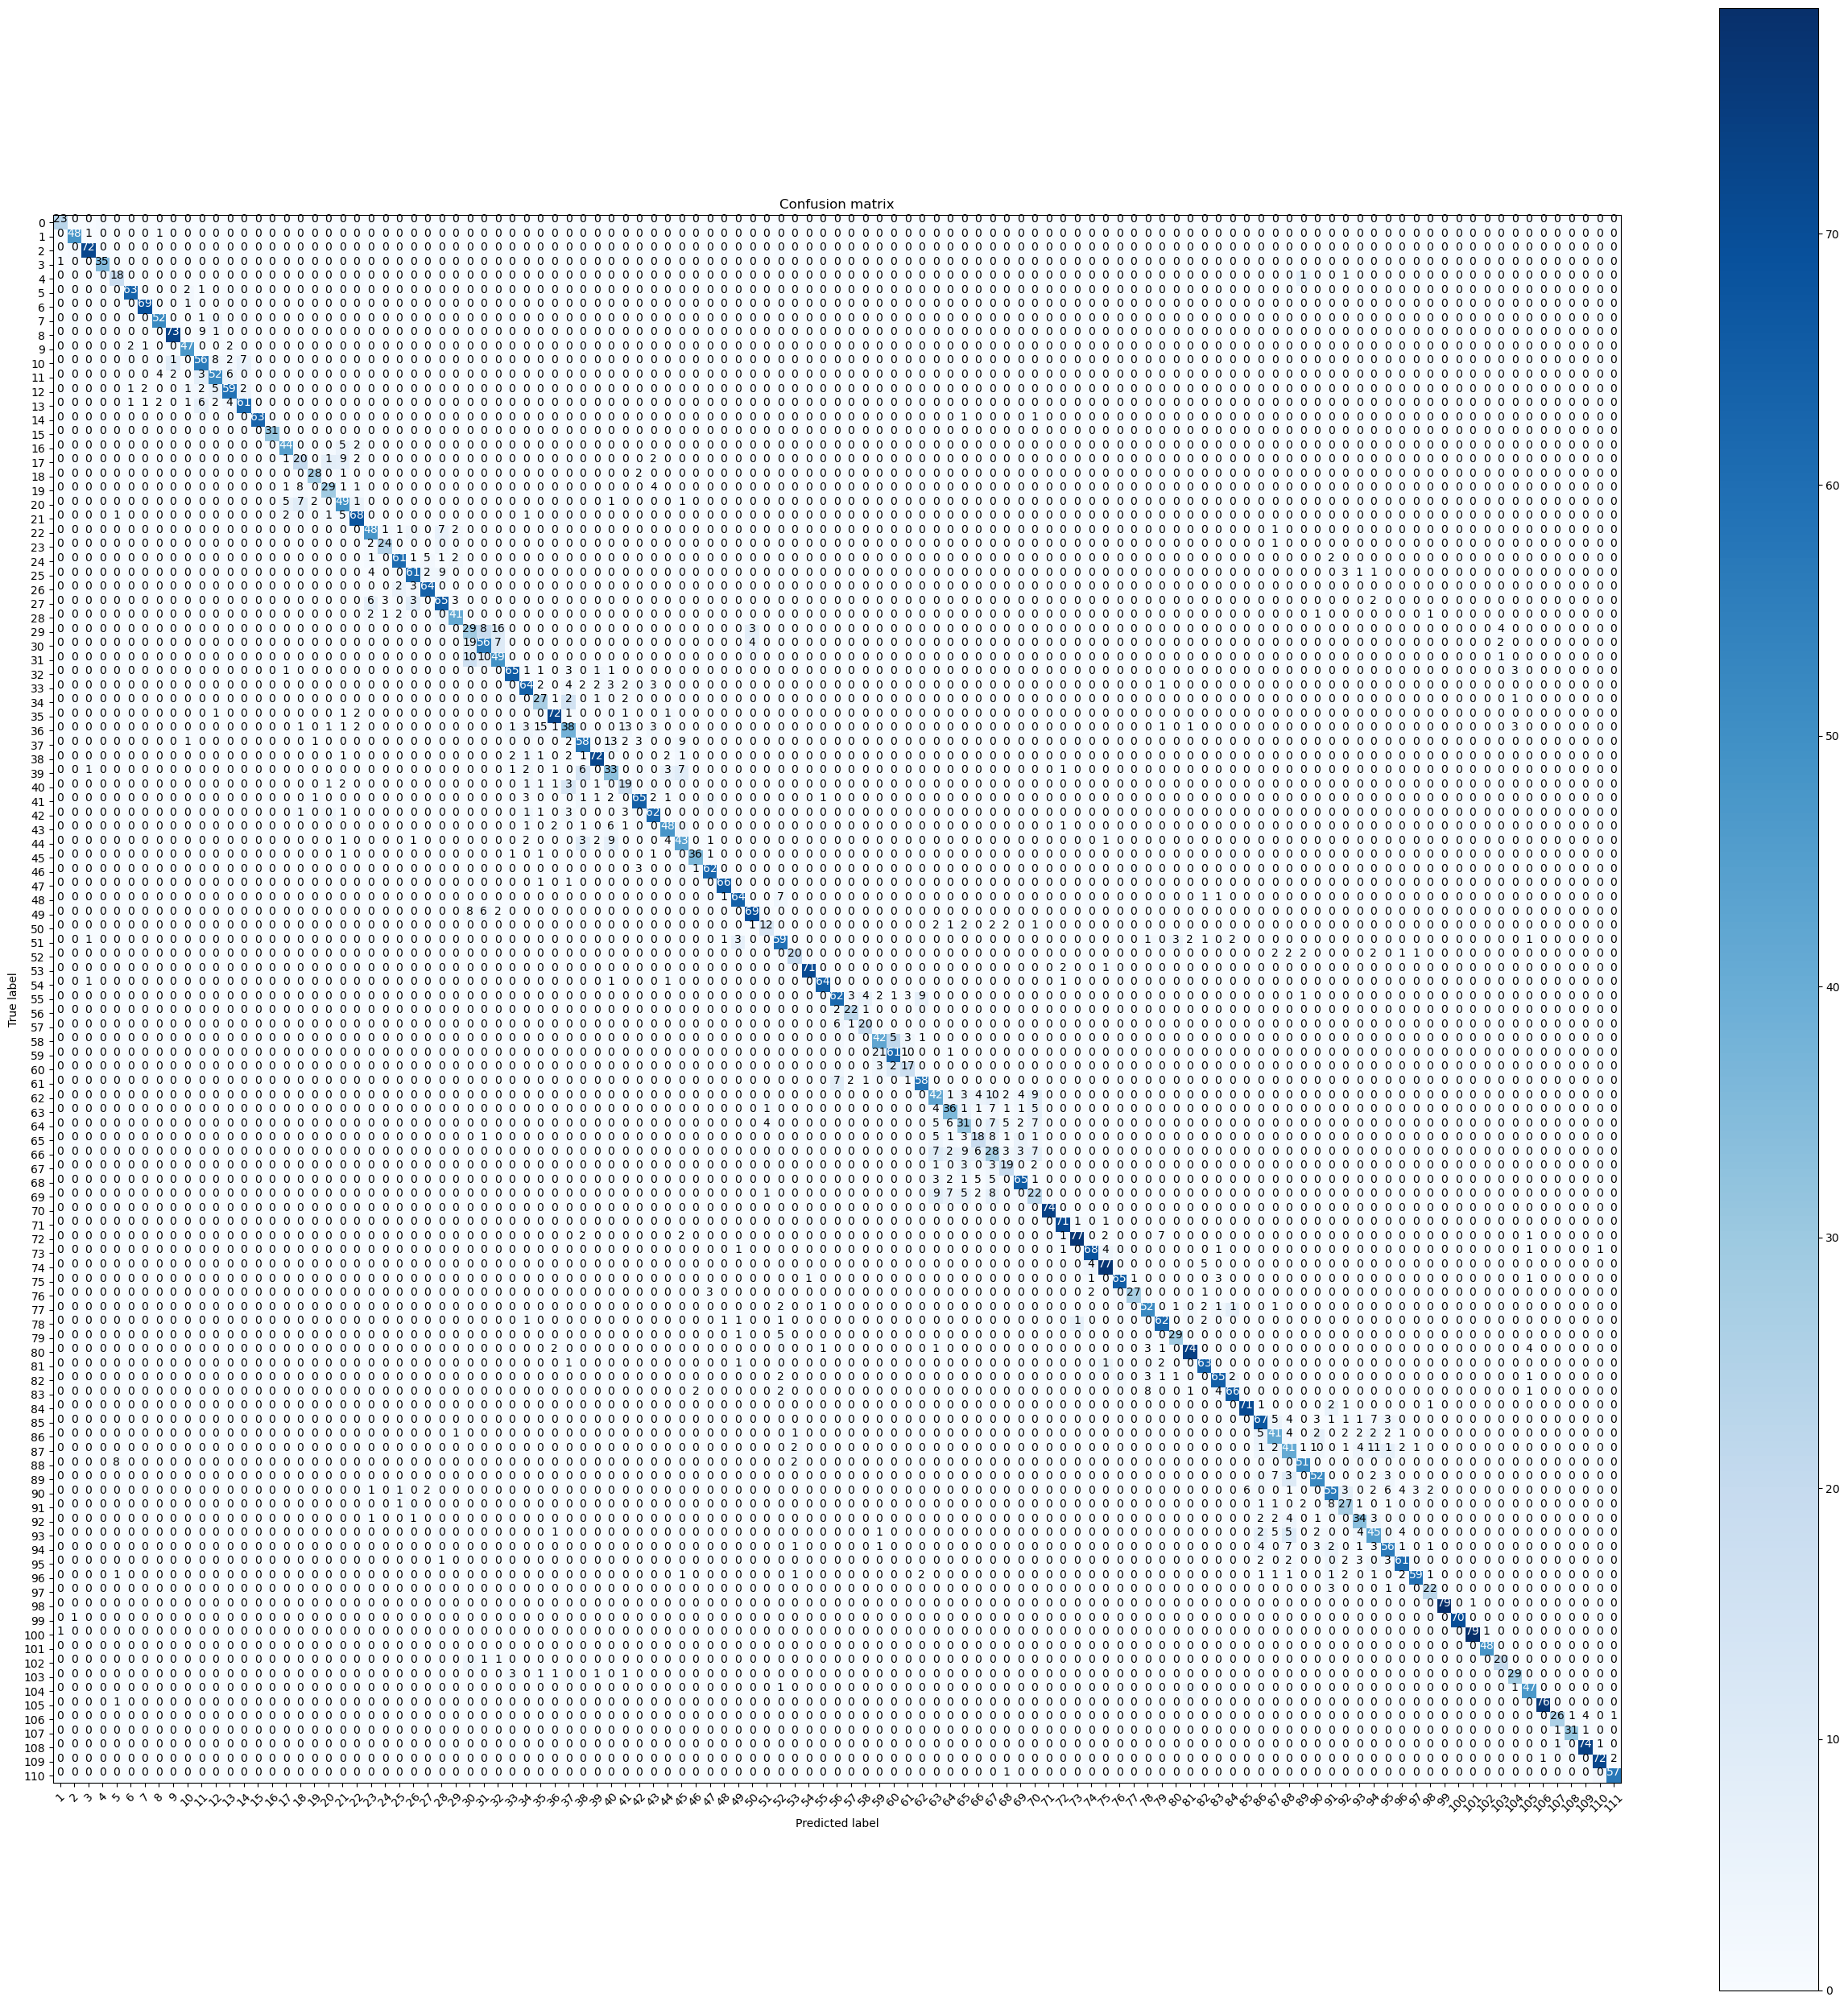

                                                      precision    recall  f1-score   support

                               accessories~belts~n/d       1.00      0.92      0.96        25
                                accessories~hats~n/d       0.96      0.98      0.97        49
                             accessories~scarves~n/d       1.00      0.95      0.97        76
                          accessories~sunglasses~n/d       0.97      1.00      0.99        35
activewear~performance trousers~performance leggings       0.90      0.62      0.73        29
                                  bags~backpacks~n/d       0.95      0.94      0.95        67
                                  bags~belt bags~n/d       0.99      0.95      0.97        73
                                bags~bucket bags~n/d       0.98      0.88      0.93        59
                                bags~clutch bags~n/d       0.88      0.96      0.92        76
                             bags~messenger bags~n/d       

In [62]:
# summary.show_sample_metrics(0)
# summary.show_sample_metrics(1)

label_by_class = {row['branch_seq']: row['branch'] for _, row in train_set[['branch_seq', 'branch']].drop_duplicates().iterrows() }

summary.plot_metrics(label_by_class=label_by_class)

In [63]:
report_generator = ml.FailReportGenerator(tokenizer, test_set, test_dataset, summary.targets, summary.predictions, IMAGES_PATH)

report = report_generator()
report.to_csv(f'{DATASET_PATH}/bet-model-fail-report.csv', index=False)

Total Fails: 19.12%


,id,description,true_class,true_image,pred_class,pred_image
0,17675766,"A BETTER BLUE X - Pose jeans women. Cotton, Hemp",clothing~denim~straight-leg jeans,,clothing~denim~cropped jeans,
1,16942756,"CH2 GFX pouch men. Polyester, Polyurethane",bags~messenger bags~n/d,,bags~belt bags~n/d,
2,16727129,Salt Wash Court shorts men. Cotton,clothing~shorts~track & running shorts,,clothing~shorts~bermuda shorts,
3,16435895,logo - lettering rain jacket women. Polyester,clothing~jackets~bomber jackets,,clothing~coats~trench & raincoats,
4,17569622,multi - pocket cargo trousers men. Cotton,clothing~trousers~skinny trousers,,clothing~trousers~tapered trousers,
5,17790569,"satin - finish draped - detail skirt women. Polyester, Acetate",clothing~skirts~fitted skirts,,clothing~skirts~asymmetric & draped skirts,
6,17013171,"embroidered logo hooded sweatshirt women. Cotton, Polyester",clothing~tops~hoodies,,clothing~tops~sweatshirts,
7,16726357,"long - sleeve quilted coat women. Polyester, Cotton",clothing~jackets~puffer jackets,,clothing~coats~parka coats,
8,17153820,"single - breasted wool blazer women. Wool, viscose",clothing~jackets~fitted jackets,,clothing~jackets~blazers,
9,16549914,"flared linen trousers women. Linen / Flax, Polyester",clothing~trousers~slim-fit trousers,,clothing~trousers~flared trousers,
